# Architecture testing with supervised learning

In this notebook I want to test the well-functioning of the various architectures proposed for the actor and the critic.

The setup is the following:
1. Generate a series of states s
2. Use optimal policy to associate them with an optimal action* a 
3. Train only the actor architecture with cross-entropy loss

*one could also use the optimal probabilities if known, but anyway if done in an unbiased way, the sampling procedure will be enough to learn stochastic policies.

Since we already have an optimal policy implemented for sandbox environment and all the code ready for playing episodes, we can build a training set starting from trajectories and then sample simple (s,a) tuples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from Utils import test_env, utils
from Utils.supervised import *

from RelationalModule import AC_networks as nets
from RelationalModule.MLP_AC_networks import Actor

from importlib import reload

In [2]:
reload(test_env)

<module 'Utils.test_env' from '/m/home/home9/94/dainesn1/unix/Workdir/RelationalDeepRL/Utils/test_env.py'>

# Coordinate state representation

In [3]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 20

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=False, return_coord=True)

In [5]:
lr = 5e-4
n_epochs = 50
coord_net = Actor(action_space=4, observation_space=5, hiddens=[64,32,16])

In [26]:
# results = supervised_training(coord_net, lr, n_epochs, 100000, game_params)

In [5]:
state_set, action_set = create_action_state_set(game_params, size=10000, get_probs=True)

In [6]:
action_set[0] # now are probabilities instead of actions

array([0. , 0.5, 0.5, 0. ])

In [6]:
results = supervised_training(coord_net, lr, n_epochs, 100000, game_params, get_probs=True)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 1, 100% 	 Train loss: 0.2153 took: 1.95s  Val. loss: 0.1595
Epoch 2, 100% 	 Train loss: 0.1293 took: 1.68s  Val. loss: 0.1194
Epoch 3, 100% 	 Train loss: 0.1105 took: 1.66s  Val. loss: 0.1080
Epoch 4, 100% 	 Train loss: 0.1018 took: 1.40s  Val. loss: 0.1005
Epoch 5, 100% 	 Train loss: 0.0949 took: 1.72s  Val. loss: 0.0943
Epoch 6, 100% 	 Train loss: 0.0890 took: 1.40s  Val. loss: 0.0884
Epoch 7, 100% 	 Train loss: 0.0837 took: 1.69s  Val. loss: 0.0843
Epoch 8, 100% 	 Train loss: 0.0797 took: 1.65s  Val. loss: 0.0804
Epoch 9, 100% 	 Train loss: 0.0771 took: 1.57s  Val. loss: 0.0783
Epoch 10, 100% 	 Train loss: 0.0755 took: 1.57s  Val. loss: 0.0772
Epoch 11, 100% 	 Train loss: 0.0744 took: 1.57s  Val. loss: 0.0764
Epoch 12, 100% 	 Train loss: 0.0737 took: 1.58s  Val. loss: 0.0765
Epoch 13, 100% 	 Train loss: 0.0732 took: 1.65s  Val. loss: 0.0758
Epoch 14, 100% 	 Train loss: 0.0728 took: 1.76s  Val. loss: 0.0751
Epoch 15, 100% 	 Train loss: 0.0725 took: 1.71s  Val. loss: 0.0747
Epoc

In [9]:
trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

In [10]:
import string
import random

save = True
keywords = ['coord','KL_div','10by10','100000-samples','50-epochs','lr5e-4'] # example

if save:
    save_dir = 'Results/Sandbox/Supervised/'
    ID = ''.join([random.choice(string.ascii_letters) for _ in range(4)])
    ID = ID.upper()
    keywords.append(ID)
    filename = '_'.join(keywords)
    filename = 'S_'+filename
    print("Save at "+save_dir+filename)
    torch.save(trained_net, save_dir+"net_"+filename)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/Supervised/S_coord_KL_div_10by10_100000-samples_50-epochs_lr5e-4_EPWF


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Actor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be ch

In [97]:
load_dir = 'Results/Sandbox/Supervised/'
coord_trained_net = torch.load(load_dir+"net_S_coord_10by10_100000-samples_20-epochs_lr5e-4_XVOF")
#coord_trained_net = torch.load(load_dir+"net_S_coord_KL_div_10by10_100000-samples_50-epochs_lr5e-4_EPWF")

In [12]:
# state set = [x_agent, y_agent, x_goal, y_goal, near_boundary]
X, Y = env.boundary[0], env.boundary[1]
x_agent = (state_set[:,0]*X).astype(int)
y_agent = (state_set[:,1]*Y).astype(int)
x_goal = (state_set[:,2]*X).astype(int)
y_goal = (state_set[:,3]*Y).astype(int)

possible_combinations = (X**2)*(Y**2)
print("Possible number of states: ", possible_combinations)


Possible number of states:  10000


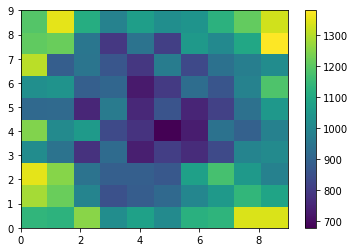

In [13]:
plt.hist2d(x_goal, y_goal, bins = [X,Y])
plt.colorbar()
plt.show()

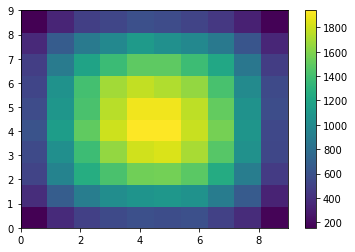

In [14]:
plt.hist2d(x_agent, y_agent, bins = [X,Y])
plt.colorbar()
plt.show()

The dataset is unbalanced in the experience... 

In [15]:
def random_start(X=10, Y=10):
    s1, s2 = np.random.choice(X*Y, 2, replace=False)
    initial = [s1//X, s1%X]
    goal = [s2//X, s2%X]
    return initial, goal

In [12]:
initials = []
goals = []
N = 100000
for i in range(N):
    initial, goal = random_start(10,10)
    initials.append(initial)
    goals.append(goal)

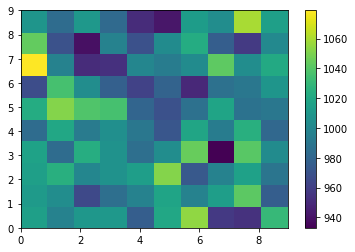

In [13]:
initials = np.array(initials)
x_initials = initials[:,0]
y_initials = initials[:,1]
plt.hist2d(x_initials, y_initials, bins = [10,10])
plt.colorbar()
plt.show()

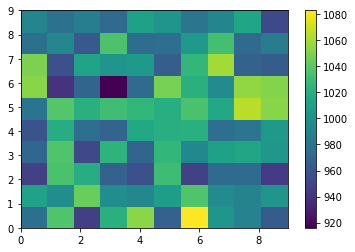

In [14]:
goals = np.array(goals)
x_goals = goals[:,0]
y_goals = goals[:,1]
plt.hist2d(x_goals, y_goals, bins = [10,10])
plt.colorbar()
plt.show()

This is not because of the initial conditions, but probably is due to the fact that all info that we collect comes from real trajectories! So basically we see more the goals in the corners because it takes more time to get there on average, so they are present in more frames. At the same time, we see the agent more in the center probably because it's the place where it passes more times. A work around on this is to avoid playing the whole episode and just taking the initial state and the optimal action in that state.

In [17]:
env = test_env.Sandbox(**game_params)

# choose state and see if the agent classifies it correctly
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# vertical direction is x (first coordinate)
# horizontal direction is y (second coordinate)
state = [4,2]
goal = [4,4]
env.state = state
env.goal = goal
enc_state = env.enc_to_coord()
x = torch.tensor(enc_state).float().to(device)
log_probs = coord_trained_net(x)
probs = torch.exp(log_probs)
for i in range(4):
    print("Action "+env.action_dict[i]+" taken with p = %.2f"%(probs[i]*100))
print(env)

Action Right taken with p = 88.74
Action Left taken with p = 0.00
Action Down taken with p = 3.75
Action Up taken with p = 7.52
Use greyscale state:  False
Use coordinate state:  True
Use one hot encoding state:  False
Boundary:  [10 10]
Initial position:  [7 8]
Current position:  [4, 2]
Goal position:  [4, 4]
Optimal actions: 
	Right
Greyscale representation: 
 [[[3 3 3 3 3 3 3 3 3 3 3 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 1 0 2 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 3 3 3 3 3 3 3 3 3 3 3]]]



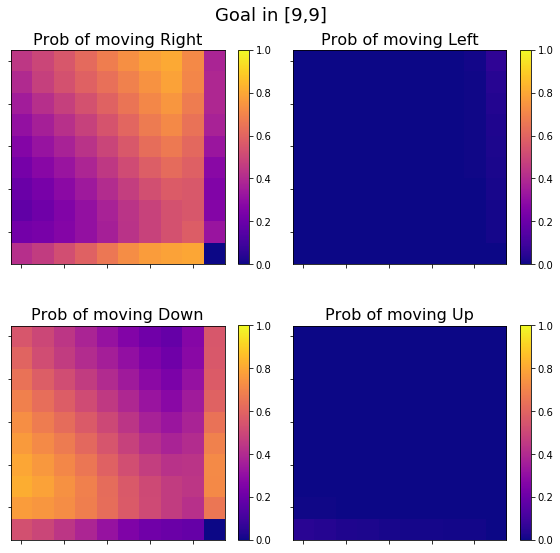

In [99]:
goal = [9,9]
probs = plot_decision_map(env, coord_trained_net, goal)

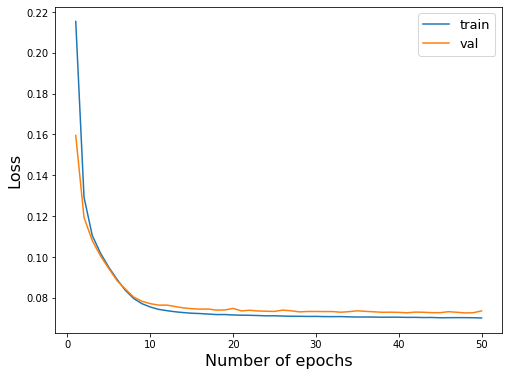

In [21]:
%matplotlib inline
plot_results(train_loss, val_loss)

In [22]:
coord_agent = OheAgent(trained_net, device='cuda')

In [23]:
game_params['initial'] = [0,8]
game_params['goal'] = [9,9]

env = test_env.Sandbox(**game_params)

In [24]:
reload(utils)

<module 'Utils.utils' from '/m/home/home9/94/dainesn1/unix/Workdir/RelationalDeepRL/Utils/utils.py'>

<IPython.core.display.Javascript object>


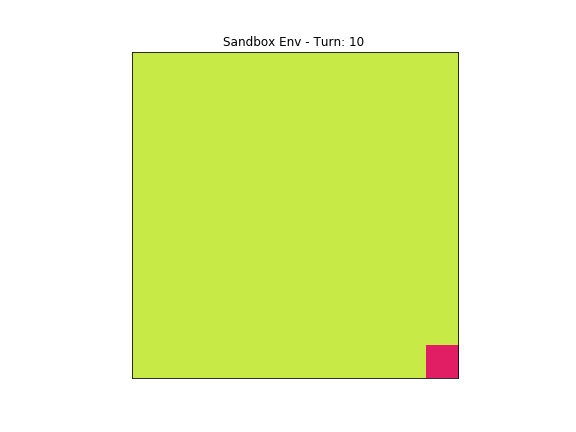

In [25]:
%matplotlib notebook
utils.render(coord_agent, env=env, greedy=True)

%matplotlib inline

## Difference of coordinate

In [31]:
def supervised_training_v1(net, lr, n_epochs, n_samples, game_params, get_probs=False):
    env = test_env.Sandbox(**game_params)
    print("\nCreating dataset...")
    state_dataset, action_set = create_action_state_set(game_params, size=n_samples, get_probs=get_probs)
    state_set = np.zeros((n_samples,2))
    state_set[:,0] = state_dataset[:,2]-state_dataset[:,0]
    state_set[:,1] = state_dataset[:,3]-state_dataset[:,1]
    train_loader, val_loader, test_loader = prepare_dataset(state_set, action_set, 0.8, 0.2)
    dataloader_dict = dict(train_loader=train_loader,
                           val_loader=val_loader,
                           test_loader=test_loader)
    print("\nTraining network...")
    net, train_loss, val_loss = train_NN(net, lr, n_epochs, train_loader, val_loader, 
                                         return_model=True, KL_loss=get_probs)
    
    return net, train_loss, val_loss, dataloader_dict, state_set, action_set, env

In [28]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 20

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=False, return_coord=True)

In [29]:
lr = 5e-4
n_epochs = 20
diff_coord_net = Actor(action_space=4, observation_space=2, hiddens=[64,32,16])

In [32]:
results = supervised_training_v1(diff_coord_net, lr, n_epochs, 100000, game_params, get_probs=True)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 1, 100% 	 Train loss: 0.2061 took: 1.71s  Val. loss: 0.1442
Epoch 2, 100% 	 Train loss: 0.1259 took: 1.74s  Val. loss: 0.1136
Epoch 3, 100% 	 Train loss: 0.1061 took: 1.79s  Val. loss: 0.0983
Epoch 4, 100% 	 Train loss: 0.0945 took: 1.57s  Val. loss: 0.0903
Epoch 5, 100% 	 Train loss: 0.0896 took: 1.61s  Val. loss: 0.0878
Epoch 6, 100% 	 Train loss: 0.0879 took: 1.62s  Val. loss: 0.0869
Epoch 7, 100% 	 Train loss: 0.0873 took: 1.56s  Val. loss: 0.0864
Epoch 8, 100% 	 Train loss: 0.0870 took: 1.59s  Val. loss: 0.0862
Epoch 9, 100% 	 Train loss: 0.0868 took: 1.58s  Val. loss: 0.0861
Epoch 10, 100% 	 Train loss: 0.0868 took: 1.58s  Val. loss: 0.0860
Epoch 11, 100% 	 Train loss: 0.0867 took: 1.60s  Val. loss: 0.0861
Epoch 12, 100% 	 Train loss: 0.0867 took: 1.57s  Val. loss: 0.0860
Epoch 13, 100% 	 Train loss: 0.0866 took: 1.56s  Val. loss: 0.0859
Epoch 14, 100% 	 Train loss: 0.0866 took: 1.57s  Val. loss: 0.0859
Epoch 15, 100% 	 Train loss: 0.0866 took: 1.78s  Val. loss: 0.0860
Epoc

In [33]:
diff_trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

In [34]:
def plot_decision_map_v1(env, net, goal):
    env.goal = goal
    
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    probabilities = []
    for x in range(env.boundary[0]):
        for y in range(env.boundary[1]):
            if [x,y] != goal:
                env.state = [x,y]
                encoded_state = env.enc_to_coord()
                enc_state = np.array([encoded_state[2]-encoded_state[0],encoded_state[3]-encoded_state[1]])
                enc_state = torch.tensor(enc_state).float().to(device)
                log_probs = net(enc_state).squeeze()
                probs = torch.exp(log_probs).cpu().detach().numpy()
                
            else:
                probs = np.zeros(env.n_actions)
            probabilities.append(probs)
            
    probs = np.array(probabilities).reshape((env.boundary[0],env.boundary[1],-1))
    
    fig = plt.figure(figsize=(8,8))
    fig.suptitle('Goal in [%d,%d]'%(goal[0],goal[1]), fontsize=18, y=1, x=0.48)
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    ax3 = plt.subplot(2,2,3)
    ax4 = plt.subplot(2,2,4)
    axes = [ax1, ax2, ax3, ax4]
    for i, ax in enumerate(axes):
        im = ax.imshow(probs[:,:,i], cmap='plasma', vmin=0, vmax=1)
        ax.set_title("Prob of moving "+env.action_dict[i], fontsize=16)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        fig.colorbar(im, ax=ax, shrink=0.77)
    plt.tight_layout()
    
    return probs

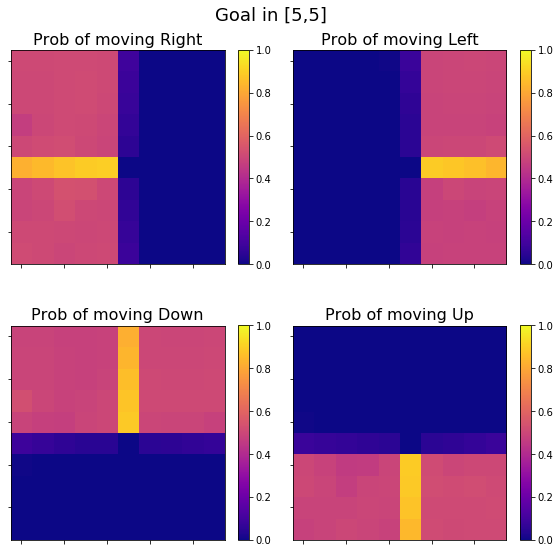

In [36]:
goal = [5,5]
probs = plot_decision_map_v1(env, diff_trained_net, goal)

## One Hot Encoded state representation

In [37]:
# Variable parameters
X = 5
Y = 5
initial = [0,0]
goal = [2,2]
MAX_STEPS = 100

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [46]:
lr = 5e-4
n_epochs = 20
ohe_net = nets.OheActor(action_space=4, map_size=5) #check mapsize

In [47]:
%%time
results = supervised_training(ohe_net, lr, n_epochs, 10000, game_params, get_probs=True)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True
Epoch 1, 10% 	 Train loss: 0.3374 took: 0.11s  

/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 1, 100% 	 Train loss: 0.2721 took: 1.11s  Val. loss: 0.2563
Epoch 2, 100% 	 Train loss: 0.2449 took: 1.15s  Val. loss: 0.2300
Epoch 3, 100% 	 Train loss: 0.2157 took: 1.13s  Val. loss: 0.2022
Epoch 4, 100% 	 Train loss: 0.1924 took: 1.13s  Val. loss: 0.1823
Epoch 5, 100% 	 Train loss: 0.1756 took: 1.15s  Val. loss: 0.1665
Epoch 6, 100% 	 Train loss: 0.1630 took: 1.13s  Val. loss: 0.1551
Epoch 7, 100% 	 Train loss: 0.1540 took: 1.14s  Val. loss: 0.1554
Epoch 8, 100% 	 Train loss: 0.1478 took: 1.14s  Val. loss: 0.1432
Epoch 9, 100% 	 Train loss: 0.1420 took: 1.12s  Val. loss: 0.1370
Epoch 10, 100% 	 Train loss: 0.1370 took: 1.10s  Val. loss: 0.1382
Epoch 11, 100% 	 Train loss: 0.1337 took: 1.14s  Val. loss: 0.1324
Epoch 12, 100% 	 Train loss: 0.1305 took: 1.12s  Val. loss: 0.1357
Epoch 13, 100% 	 Train loss: 0.1299 took: 1.10s  Val. loss: 0.1287
Epoch 14, 100% 	 Train loss: 0.1278 took: 1.10s  Val. loss: 0.1344
Epoch 15, 100% 	 Train loss: 0.1257 took: 1.11s  Val. loss: 0.1268
Epoc

0.1106

In [48]:
trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

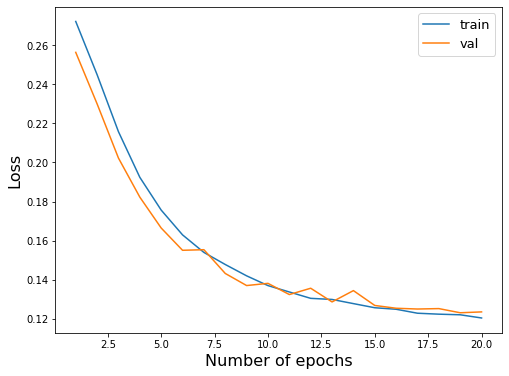

In [49]:
plot_results(train_loss, val_loss)

As a result I don't expect a loss of 0, because in many states there are 2 possible choices to make, e.g. if I have to go right and down, I can equally go down and then left, so each choice can be taken with arbitrary probability, as long as the choice remains between the two actions (said in other words, the probability of choosing one of those 2 actions is 1).

Anyway, the loss function is the average of - log of the probability of coosing the optimal action, so will be 0 if all actions are certain and the network classifies all of them correctly, and will be -log(0.5) = 0.693 if every action is selected with 0.5 probability. So for sure an optimal classifier should score less than 0.693 to be said so (because there are states where a single optimal action is possible).

Actually if we assume all states to be equally probable (that is a bad assumption actually, because we will always find more states where the agent is near the goal if the states are collected from optimal trajectories), we can make a computation to see how much the optimal loss should be.

Calling X the linear size of the map, we have 2X-2 states out of X^2 - 1 in which there is only an optimal action, and X^2 - 1 - 2X + 2 in which there are 2. 

$$ L(X) = -\frac{2X-2}{X^2 - 1}log(1) - \frac{X^2 - 2X + 1}{X^2 - 1}log(0.5) = \frac{X-1}{X+1}\cdot0.69$$

hence L(5) = 0.46.

This training is far from optimal and that probably depends on the fact that is failing to recognize corners and walls...

### From supervised to real actor

To test how the training looks like, we can use the net to see if the result is optimal or not.

In [50]:
ohe_agent = OheAgent(trained_net, device='cuda')

In [51]:
game_params['initial'] = [0,0]
game_params['goal'] = [3,3]

env = test_env.Sandbox(**game_params)

<IPython.core.display.Javascript object>


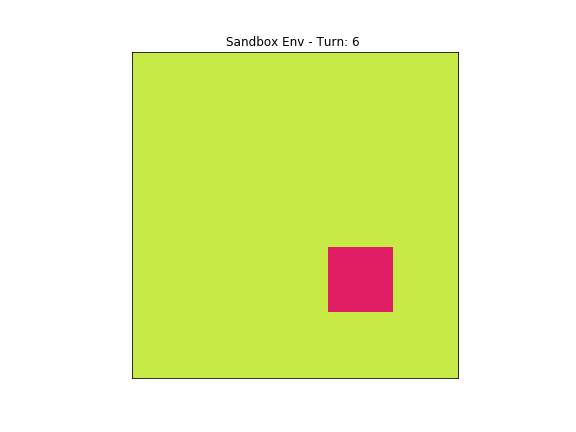

In [52]:
%matplotlib notebook
utils.render(ohe_agent, env=env, greedy=False)

%matplotlib inline

# Relational agent

In [3]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 20

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [83]:
lr = 5e-4
n_epochs = 100

HPs = dict(n_features=64, n_heads=4,  n_attn_modules=2, feature_hidden_dim=128, feature_n_residuals=2)
relational_actor_net = nets.GatedBoxWorldActor(action_space=4, **HPs)

In [84]:
results = supervised_training(relational_actor_net, lr, n_epochs, 10000, game_params, get_probs=True)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True
Epoch 1, 100% 	 Train loss: 0.2574 took: 1.89s  Val. loss: 0.2582
Epoch 2, 100% 	 Train loss: 0.2564 took: 1.91s  Val. loss: 0.2586
Epoch 3, 100% 	 Train loss: 0.2515 took: 1.86s  Val. loss: 0.2332
Epoch 4, 100% 	 Train loss: 0.1909 took: 1.70s  Val. loss: 0.1743
Epoch 5, 100% 	 Train loss: 0.1596 took: 1.82s  Val. loss: 0.1583
Epoch 6, 100% 	 Train loss: 0.1498 took: 1.91s  Val. loss: 0.1489
Epoch 7, 100% 	 Train loss: 0.1255 took: 1.84s  Val. loss: 0.1109
Epoch 8, 100% 	 Train loss: 0.1013 took: 1.86s  Val. loss: 0.0987
Epoch 9, 100% 	 Train loss: 0.0919 took: 1.85s  Val. loss: 0.0926
Epoch 10, 100% 	 Train loss: 0.0895 took: 1.83s  Val. loss: 0.0901
Epoch 11, 100% 	 Train loss: 0.0866 took: 1.85s  Val. loss: 0.0887
Epoch 12, 100% 	 Train loss: 0.0835 took: 1.86s  Val. loss: 0.0843
Epoch 13, 100% 	 Train loss: 0.0803 took: 1.80s  Val. loss: 0.0850
Epoch 14, 100% 	 Train loss: 0.0792 took: 1.89s  Val. loss: 0.0

0.0749

In [85]:
relational_trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

In [60]:
import string
import random

save = True
keywords = ['relational','KL_div','10by10','100000-samples','50-epochs','lr5e-4'] # example

if save:
    save_dir = 'Results/Sandbox/Supervised/'
    ID = ''.join([random.choice(string.ascii_letters) for _ in range(4)])
    ID = ID.upper()
    keywords.append(ID)
    filename = '_'.join(keywords)
    filename = 'S_'+filename
    print("Save at "+save_dir+filename)
    torch.save(relational_trained_net, save_dir+"net_"+filename)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/Supervised/S_relational_KL_div_10by10_100000-samples_50-epochs_lr5e-4_KVNX


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GatedBoxWorldActor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GatedBoxWorldNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__nam

In [2]:
load_dir = 'Results/Sandbox/Supervised/'
#relational_trained_net = torch.load(load_dir+"net_S_relational_10by10_100000-samples_50-epochs_lr5e-4_CQBC")
relational_trained_net = torch.load(load_dir+"net_S_relational_KL_div_10by10_100000-samples_50-epochs_lr5e-4_KVNX")

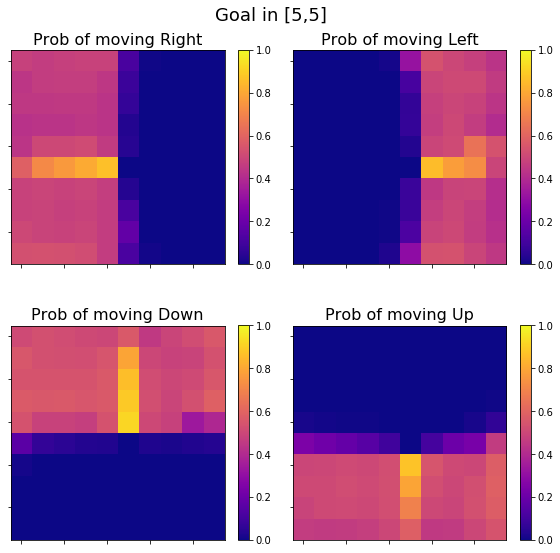

In [86]:
goal = [5,5]
probs = plot_decision_map(env, relational_trained_net, goal, coord=False)

In [63]:
relational_agent = OheAgent(relational_trained_net, device='cuda')

In [65]:
game_params['initial'] = [2,1]
game_params['goal'] = [9,9]

env = test_env.Sandbox(**game_params)

<IPython.core.display.Javascript object>


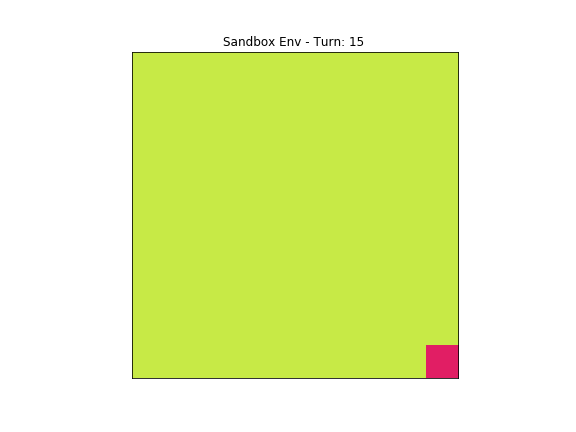

In [66]:
%matplotlib notebook
utils.render(relational_agent, env=env, greedy=True)

%matplotlib inline

# Multiplicative net

In [2]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 25

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [15]:
lr = 1e-4
n_epochs = 100

HPs = dict(linear_size = X+2,
           in_channels = 3,
           hidden_channels=[12],
           max_pool_size = 3,
           n_features = 16
          )
multi_actor_net = nets.MultiplicativeActor(action_space=4, **HPs)

In [ ]:
results = supervised_training(multi_actor_net, lr, n_epochs, 10000, game_params, get_probs=True)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  False
Epoch 1, 100% 	 Train loss: 0.2628 took: 1.71s  Val. loss: 0.2718
Epoch 2, 100% 	 Train loss: 0.2619 took: 1.71s  Val. loss: 0.2706
Epoch 3, 100% 	 Train loss: 0.2612 took: 1.70s  Val. loss: 0.2700
Epoch 4, 100% 	 Train loss: 0.2606 took: 1.69s  Val. loss: 0.2691
Epoch 5, 100% 	 Train loss: 0.2601 took: 1.67s  Val. loss: 0.2689
Epoch 6, 100% 	 Train loss: 0.2596 took: 1.69s  Val. loss: 0.2671
Epoch 7, 100% 	 Train loss: 0.2592 took: 0.99s  Val. loss: 0.2668
Epoch 8, 100% 	 Train loss: 0.2589 took: 0.98s  Val. loss: 0.2662
Epoch 9, 100% 	 Train loss: 0.2587 took: 0.99s  Val. loss: 0.2646
Epoch 10, 100% 	 Train loss: 0.2585 took: 0.97s  Val. loss: 0.2645
Epoch 11, 100% 	 Train loss: 0.2583 took: 0.97s  Val. loss: 0.2646
Epoch 12, 100% 	 Train loss: 0.2581 took: 0.97s  Val. loss: 0.2638
Epoch 13, 100% 	 Train loss: 0.2580 took: 0.97s  Val. loss: 0.2641
Epoch 14, 100% 	 Train loss: 0.2579 took: 0.98s  Val. loss: 0.

0.0757

In [10]:
multi_trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

In [ ]:
grey_state = env.enc_to_grey()
enc_state = env.grey_to_onehot(grey_state)

In [6]:
import string
import random

save = False
keywords = ['multiplicative','convolutional'] # example

if save:
    save_dir = 'Results/Sandbox/Supervised/'
    ID = ''.join([random.choice(string.ascii_letters) for _ in range(4)])
    ID = ID.upper()
    keywords.append(ID)
    filename = '_'.join(keywords)
    filename = 'S_'+filename
    print("Save at "+save_dir+"net_"+filename)
    torch.save(multi_trained_net, save_dir+"net_"+filename)
else:
    print("Nothing saved")
    pass

Nothing saved


In [7]:
load_dir = 'Results/Sandbox/Supervised/'
multi_trained_net = torch.load(load_dir+"net_S_multiplicative_convolutional_QAXN")

In [17]:
#env = test_env.Sandbox(**game_params)

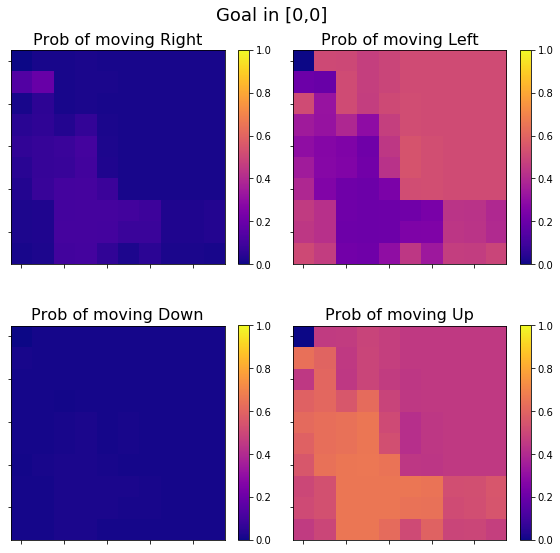

In [11]:
goal = [0,0]
probs = plot_decision_map(env, multi_trained_net, goal, coord=False)

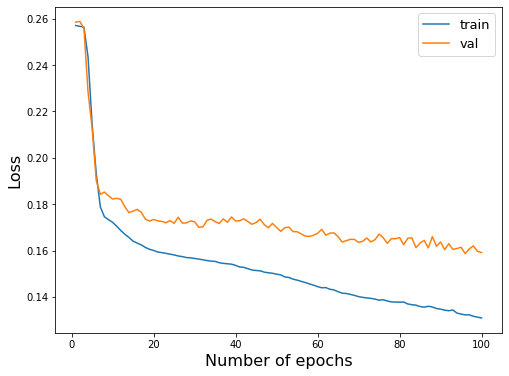

In [12]:
plot_results(train_loss, val_loss)

In [23]:
multi_agent = OheAgent(multi_trained_net, device='cpu')

In [24]:
game_params['initial'] = [5,5]
game_params['goal'] = [2,1]

env = test_env.Sandbox(**game_params)

<IPython.core.display.Javascript object>


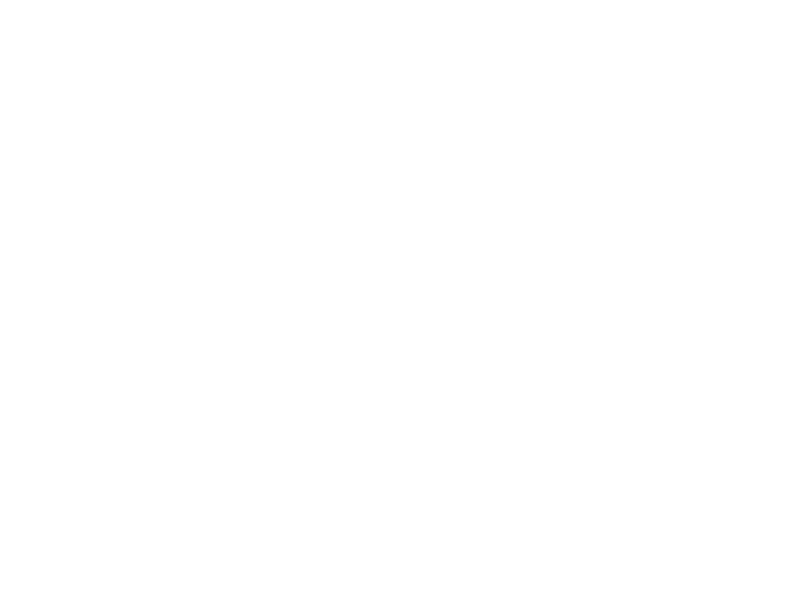

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 3 and 4 at /tmp/pip-req-build-4baxydiv/aten/src/TH/generic/THTensor.cpp:680

In [25]:
%matplotlib notebook
utils.render(multi_agent, env=env, greedy=True)

%matplotlib inline

In [26]:
%matplotlib inline